# Assignment Overview


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Question 1: Data Quality and Customer Understanding (30 points)

#### Q1.1 Please perform the exploratory data analysis of the data. (20 points)


In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [262]:
df = pd.read_excel("FarTrend_eRetail.xlsx")

In [263]:
# let's firstly check how many null values each column has
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [264]:
#as we can see, the only columns having missing values are the Description and CustomerID columns. we can consider it to be a safe approach to replace the null values in Description
#with 'No Description' and those in CustomerID being dropped since they won't be useful towards our final analysis.

df = df.fillna({'Description' : 'No Description'})
df = df.dropna(subset = ["CustomerID"]) 
df = df.fillna({'StockCode' : 'None'})


In [265]:
'''we have successfully filled those null values, now we can check if there are duplicates.
we also need to take into account that an invoice may involve more products, which are accounted for in more rows, therefore, our approach will consist of 
handling the true duplicates. '''


true_duplicates = df.duplicated().sum()
invoice_no_duplicates_count = df.duplicated(subset=["InvoiceNo"], keep=False).sum()

true_duplicates, invoice_no_duplicates_count

(5225, 403434)

In [266]:
#we can see from the result, that we have 5,268 true duplicates in the InvoiceNo column, therefore now we can make use of the drop_duplicates() function in the pandas library,
#which is quite smart since it just removes true duplicates.

df = df.drop_duplicates()

# we now verify the removal by checking the new size of the dataset and ensuring no true duplicates are left.
new_total_entries = df.shape[0]
remaining_true_duplicates = df.duplicated().sum()

new_total_entries, remaining_true_duplicates

(401604, 0)

#### Now we can go on with our EDA by checking if there are any outliers

In [267]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [268]:
neg_counts = df[['Quantity', 'UnitPrice']] < 0
neg_counts.value_counts()

Quantity  UnitPrice
False     False        392732
True      False          8872
dtype: int64

#### The confusion matrix herein above shows that there are 8,872 negative quantity values, let's investigate more on those. 

In [269]:
# we immediately can see how some descriptions are "Discount", these entries will interfer with the outcome of our analysis - we therefore decide to drop them.

df = df[df['Description'] != 'Discount']

In [270]:
#furthermore, we noticed some data in the StockCode column to be registered as strings, let's investigate more on those

str_stockcode = df[df['StockCode'].str.contains('^[a-zA-Z]+$', regex = True, na = False)]
str_stockcode['StockCode'].unique()

array(['POST', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [271]:
#since these codes don't represent anything useful towards the completion of our analysis, we decide to drop those values.

df = df[~df['StockCode'].str.contains('^[a-zA-Z]+$', regex=True, na=False)]


In [272]:
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


#### After removing some clear outliers, we notice how the negative values that we come across have the InvoiceNo starting with C, which most probably indicates refunds. We need to keep this data for the accuracy of our analysis.


In [273]:
#by giving a further look at the statistical data of the dataset, we notice how the minimum price value is 0, since this cannot be true, we decide to investigate more

df[df['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


#### As we can see, there is a lot of data with a unit price registered as 0. Given the insignificancy of this data towards the building of our model, we decide to drop all the rows. Furthermore, as a remark, the customerID seems to be not available for the rows displayed here, this is a further suggestion that this is mistakenly entered data.

In [274]:
df = df[df['UnitPrice'] > 0]

#### The last step of our preparatory analysis is Feature engineering in preparation for the following tasks. Since we are asked to segment customers, the first thing that comes to mind is to multiply quantity by price so to get the total amount of money that each customer spent.

In [275]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [276]:
#feature engineering on recency (R) of last purchase

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date

#next step is to find the most recent purchase of each customer so to segment them more effectively

customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
most_recent_date = df['InvoiceDay'].max()
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

#now computing the days since last purchase

customer_data['DaysSinceLastPurchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

#finally drop InvoiceData column, since it became useless.

customer_data.drop(columns = ['InvoiceDay'], inplace = True)


In [277]:
#feature engineering of frequency of purchases (F)

#calculating the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns = {'InvoiceNo' : 'TotalTransactions'}, inplace = True)
#now let's calculate the quantity of purchase made

total_purchases = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_purchases.rename(columns = {'Quantity' : 'TotalPurchases'})

#and finally merge everything into our new customer_data dataset

customer_data = pd.merge(customer_data, total_transactions, on = 'CustomerID')
customer_data = pd.merge(customer_data, total_purchases, on = 'CustomerID')

In [278]:
#feature engineering on monetary value (M), in other words, the total spending per customer, as well as average transaction value

#total spend calculation
total_spend = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()

#atv calculation
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['AverageTransactionValue'] = average_transaction_value['TotalPrice'] / average_transaction_value['TotalTransactions']


#finally merging
customer_data = pd.merge(customer_data, total_spend, on = 'CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'AverageTransactionValue']], on = ['CustomerID'])



In [279]:
#as another feature we can add how many unique products each customer purchased, as this can reveal important patterns
unique_products = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products.rename(columns = {'StockCode' : 'UniqueProductsPurchased'})

customer_data = pd.merge(customer_data, unique_products, on = 'CustomerID')

In [280]:
#behavioral features

#average days between purchases

df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

#favorite shopping day
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

#favorite shopping hour
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

#merging
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [281]:
df['Country'].value_counts(normalize= True)

United Kingdom          0.890771
Germany                 0.022711
France                  0.020395
EIRE                    0.018677
Spain                   0.006158
Netherlands             0.005818
Belgium                 0.004930
Switzerland             0.004610
Portugal                0.003569
Australia               0.003134
Norway                  0.002649
Italy                   0.001958
Channel Islands         0.001888
Finland                 0.001633
Cyprus                  0.001521
Sweden                  0.001091
Austria                 0.000968
Denmark                 0.000938
Japan                   0.000888
Poland                  0.000840
USA                     0.000728
Israel                  0.000618
Unspecified             0.000603
Singapore               0.000538
Iceland                 0.000455
Canada                  0.000375
Greece                  0.000355
Malta                   0.000308
United Arab Emirates    0.000168
European Community      0.000145
RSA       

In [282]:
#we can clearly see how the customers are predominantly coming from the UK, therefore, in order to target our customers better, we decide to create an additional column names is_uk
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name = 'TransactionsNumber')
customers_main_country = customer_country.sort_values('TransactionsNumber', ascending = False)
customers_main_country['is_uk'] = customers_main_country['Country'].apply(lambda x : 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customers_main_country, on = 'CustomerID', how = 'left')


In [284]:
# First, identify columns with the same name but different suffixes
cols_to_remove = [col for col in customer_data.columns if '_x' in col or '_y' in col]

# Drop these columns from the DataFrame
customer_data_cleaned = customer_data.drop(columns=cols_to_remove)

# Check for remaining columns that might be duplicates due to suffixes not being added
customer_data_cleaned = customer_data_cleaned.loc[:,~customer_data_cleaned.columns.duplicated()]

print(customer_data_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4294 entries, 0 to 4293
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4294 non-null   float64
 1   DaysSinceLastPurchase           4294 non-null   int64  
 2   TotalTransactions               4294 non-null   int64  
 3   Quantity                        4294 non-null   int64  
 4   TotalPrice                      4294 non-null   float64
 5   AverageTransactionValue         4294 non-null   float64
 6   StockCode                       4294 non-null   int64  
 7   Average_Days_Between_Purchases  4294 non-null   float64
 8   Day_Of_Week                     4294 non-null   int64  
 9   Hour                            4294 non-null   int64  
 10  Country                         4294 non-null   object 
 11  TransactionsNumber              4294 non-null   int64  
 12  is_uk                           42

In [285]:
customer_data_cleaned.drop(columns= 'TransactionsNumber')

,CustomerID,DaysSinceLastPurchase,TotalTransactions,Quantity,TotalPrice,AverageTransactionValue,StockCode,Average_Days_Between_Purchases,Day_Of_Week,Hour,Country,is_uk
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,United Kingdom,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,Iceland,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,Finland,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,Italy,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,Norway,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4289,18280.0,277,1,45,180.60,180.600000,10,0.000000,0,9,United Kingdom,1
4290,18281.0,180,1,54,80.82,80.820000,7,0.000000,6,10,United Kingdom,1
4291,18282.0,7,3,98,176.60,58.866667,12,9.916667,4,13,United Kingdom,1
4292,18283.0,3,16,1355,2039.58,127.473750,262,0.465181,3,14,United Kingdom,1


C:\Users\HEW15DW1083NL\AppData\Local\Temp\ipykernel_37920\1790635629.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = customer_data_cleaned.corr()


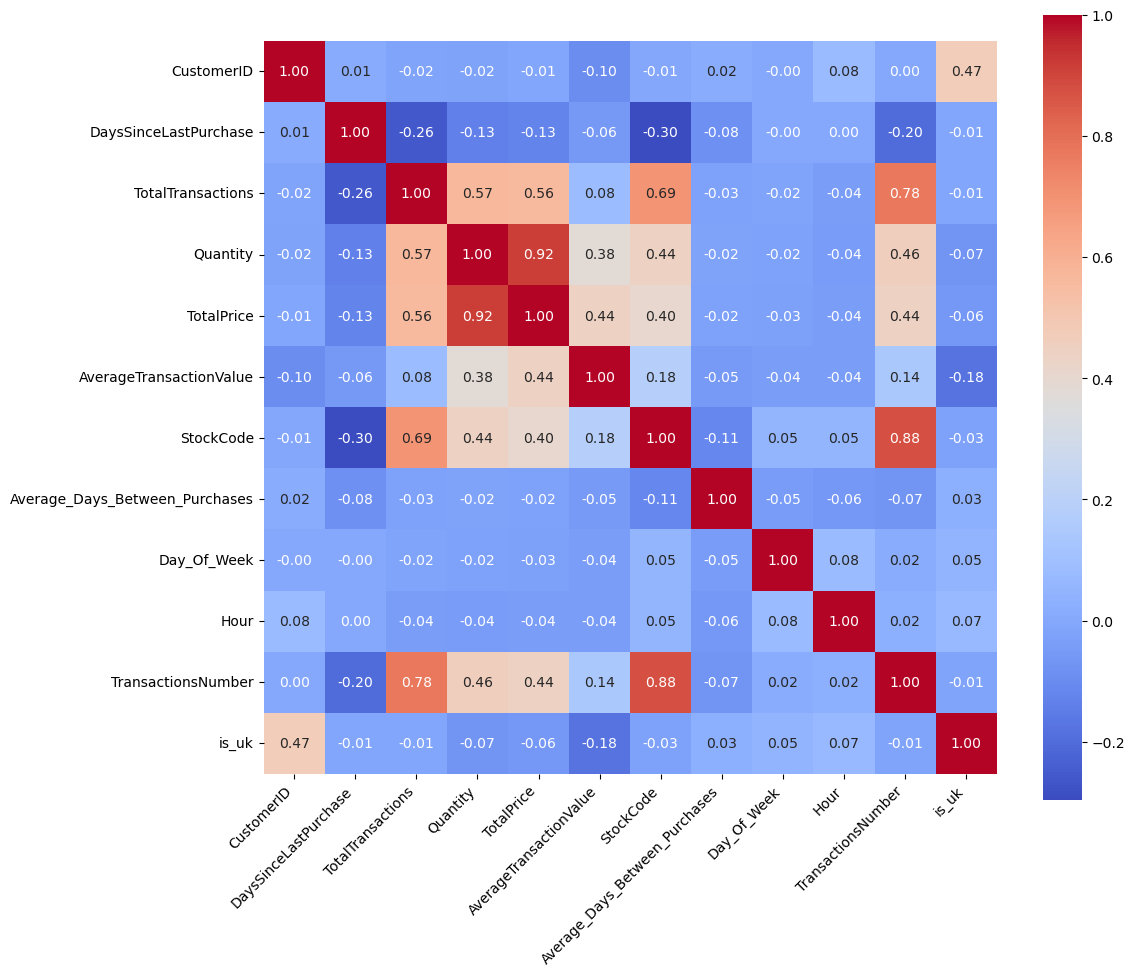

In [286]:
import seaborn as sns

correlation_matrix = customer_data_cleaned.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)

# Ensure the plot displays well with axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [287]:
#we finally need to remove outliers, this can be done by calculating the Z-score

#firstly we need to select numeric columns only
numeric_cols = customer_data_cleaned.select_dtypes(include=[np.number])

z_scores = numeric_cols.apply(zscore)

# Create a mask to filter out all rows with any Z-score greater than 3 or less than -3
mask = (z_scores.abs() <= 2.5).all(axis=1)

# Apply the mask to the DataFrame to retain only rows without any outliers
customer_data_no_outliers = customer_data[mask]

print(f"Original DataFrame shape: {customer_data.shape}")
print(f"DataFrame without outliers shape: {customer_data_no_outliers.shape}")

Original DataFrame shape: (4294, 13)
DataFrame without outliers shape: (3500, 13)


In [ ]:
#after having removed around 800 outliers, we can proceed with our baseline models.

#### After investigating, we can affirm our dataset is cleaned enough and therefore ready to be subject to building of baseline model.

#### Q1.2 Please describe in two paragraphs the main data insights. Connect the insight with the business  (10 points)


##### The initial examination and cleaning of the FarTrend eRetail dataset revealed several critical insights that have direct implications for business operations and analysis. First and foremost, the presence of missing values in the "Description" and "CustomerID" columns was addressed by filling missing descriptions with 'No Description' and removing rows without customer identifiers, ensuring that subsequent analyses would be based on transactions with complete customer data. This step is crucial for customer segmentation efforts, as analyses depend heavily on the ability to accurately track and attribute transactions to individual customers. Furthermore, the dataset contained a significant number of true duplicates, specifically within the "InvoiceNo" column, leading to the removal of these duplicates to prevent skewed analyses. The identification and exclusion of true duplicates streamline the dataset, making it more manageable and ensuring that insights drawn from the data accurately reflect unique transactions.

##### A deeper dive into the dataset uncovered negative values in both the "Quantity" and "UnitPrice" columns, alongside extreme outliers in transaction quantities. These anomalies were largely attributed to product returns or adjustments, marked by invoice numbers beginning with 'C', indicating cancellations or credits issued to customers. By addressing these outliers and removing transactions with zero unit prices—likely erroneous entries—the dataset was further refined for accuracy. Additionally, stock codes registered as strings, which do not directly contribute to transactional analysis, were identified and excluded. The final step in the dataset preparation involved creating a "TotalPrice" feature by multiplying quantity by unit price, laying the groundwork for comprehensive customer expenditure analysis. 

##### Finally, another step of Feature Engineering was taken and a new dataset called customer_data was created. This dataset contains aggregated variables that will be crucial in defining customers patterns. preparatory steps not only cleanse the dataset but also enrich it, ensuring that the forthcoming customer segmentation model is built on a robust and accurate foundation, reflective of actual purchasing behavior and patterns. This meticulous data preparation phase is pivotal for any business looking to derive meaningful insights from their transaction data, directly supporting informed decision-making and strategic planning.

## Question 2: Segment the clients based on their purchase profile (35 points)

#### Q2.1 Build a baseline model to segment the costumers. (15 points)

In [288]:
#to build our baseline model, we first need to select some features among those we have created

features = customer_data_no_outliers[['StockCode', 'Quantity', 'TotalTransactions']]

#afterwards, we apply dimensionality reduction through the principal component analysis (PCA) to be able to visualize two components

pca = PCA(n_components= 2)
features_pca = pca.fit_transform(features)

In [290]:
# we then apply feature scaling

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(features_pca)

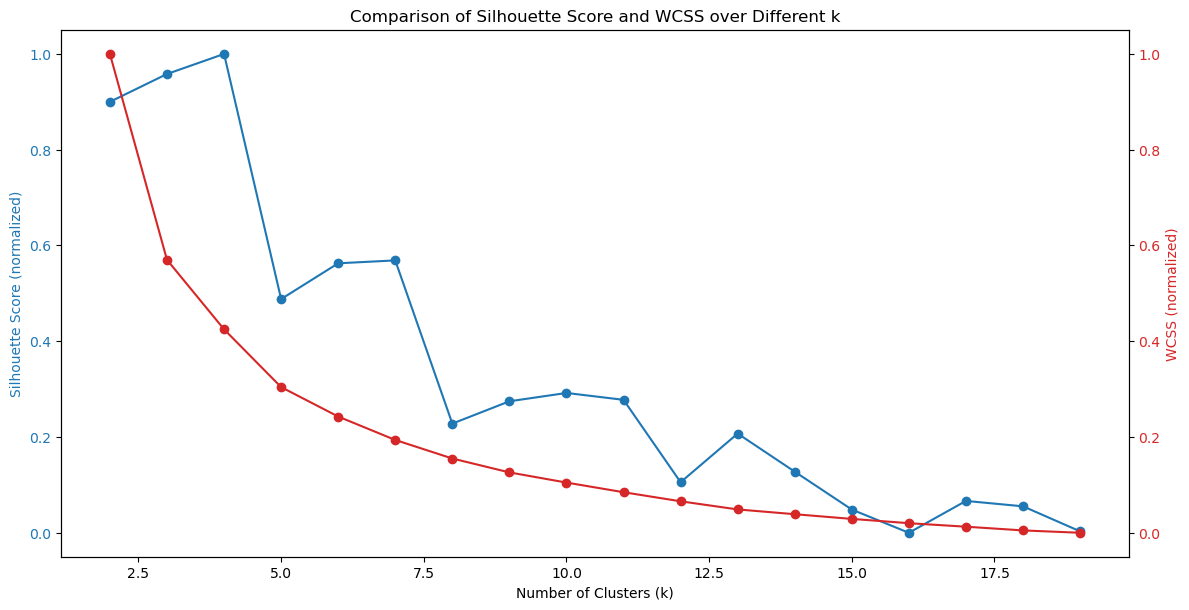

Optimal k based on silhouette score: 4


In [291]:
def evaluate(data, k):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    model = kmeans.fit(data)
    labels = model.labels_
    silhouette_avg = silhouette_score(data, labels)
    wcss = kmeans.inertia_
    return silhouette_avg, wcss

#silhouette scores and WCSS for different numbers of clusters
silhouette_scores = []
wcss_scores = []
for k in range(2, 20):
    silhouette_avg, wcss = evaluate(customer_data_scaled, k)
    silhouette_scores.append(silhouette_avg)
    wcss_scores.append(wcss)

wcss_array = np.array(wcss_scores)
wcss_normalized = (wcss_array - min(wcss_array)) / (max(wcss_array) - min(wcss_array))

# normalizing silhouette scores
silhouette_array = np.array(silhouette_scores)
silhouette_normalized = (silhouette_array - min(silhouette_array)) / (max(silhouette_array) - min(silhouette_array))

optimal_k_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2  

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score (normalized)', color='tab:blue')
ax1.plot(range(2, 20), silhouette_normalized, label='Silhouette Score (normalized)', color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('WCSS (normalized)', color='tab:red')
ax2.plot(range(2, 20), wcss_normalized, label='WCSS (normalized)', color='tab:red', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Comparison of Silhouette Score and WCSS over Different k')
plt.show()

print(f"Optimal k based on silhouette score: {optimal_k_silhouette}")


#### From this projection we can infer there is no exact point where the elbow method points at a specific clustering, whereas the silhouette score clearly points out at four clusters.

In [292]:
#we can see how the optimal number of clusters is 3, we therefore proceed to fit kmeans to our dataset
kmeans = KMeans(n_clusters= optimal_k_silhouette, random_state=1)

clusters = kmeans.fit_predict(customer_data_scaled)

c:\Users\HEW15DW1083NL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


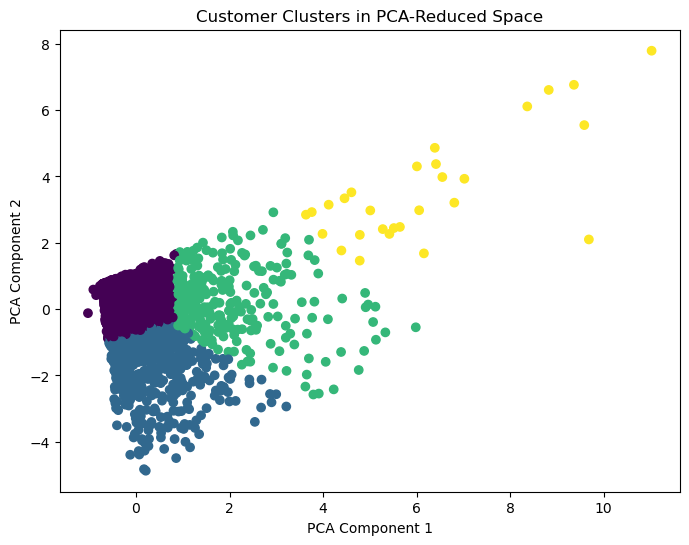

In [293]:
#and we finally visualize in the PCA reduced space

plt.figure(figsize=(8, 6))
scatter = plt.scatter(customer_data_scaled[:, 0], customer_data_scaled[:, 1], c=clusters)
plt.title('Customer Clusters in PCA-Reduced Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [294]:
#let's now detect the groups of customers in the clusters.

customer_data_no_outliers['Cluster'] = kmeans.labels_
cluster_characteristics = customer_data_no_outliers.groupby('Cluster')[['TransactionsNumber', 'Quantity', 'TotalTransactions']].mean()

C:\Users\HEW15DW1083NL\AppData\Local\Temp\ipykernel_37920\511318130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data_no_outliers['Cluster'] = kmeans.labels_


In [295]:
cluster_characteristics

,TransactionsNumber,Quantity,TotalTransactions
Cluster,,,
0,35.966769,357.200917,2.754775
1,180.751736,1034.559028,6.508681
2,168.089928,2627.924460,11.205036
3,135.892857,6757.000000,14.750000


#### Cluster 0 (Blue): This cluster has the lowest average values for TransactionsNumber, Quantity, and TotalTransactions. The points are closely packed near the origin in the PCA space, suggesting that these customers are similar in their purchasing patterns, likely representing infrequent or new customers with low transaction volume and quantities.

#### Cluster 1 (Yellow): Customers in this cluster have higher average TransactionsNumber and TotalTransactions than Cluster 0, but lower than Clusters 2 and 3. Their average Quantity is also moderate. In the PCA plot, these customers spread out a bit more, suggesting some variability within this cluster. They might represent regular customers who purchase with moderate frequency and amounts.

#### Cluster 2 (Green): This cluster is characterized by an extraordinarily high average Quantity but does not have the highest TransactionsNumber or TotalTransactions. On the plot, these points are more dispersed and extend far out along the PCA Component 2 axis, which might be heavily influenced by the Quantity feature. This cluster could represent bulk buyers who purchase large quantities in a few transactions, such as wholesale customers.

#### Cluster 3 (Purple): Cluster 3 has a high average Quantity and TotalTransactions, though not as high as Cluster 2, and a somewhat lower TransactionsNumber compared to Cluster 1. In the PCA plot, these points seem to be in between Clusters 0/1 and Cluster 2, indicating these customers might be making significant but less frequent purchases than the bulk buyers of Cluster 2—potentially high-value customers who purchase more expensive or premium items.

#### Q2.2 Build a second model to segment costumers and compare the performance. (10 points)

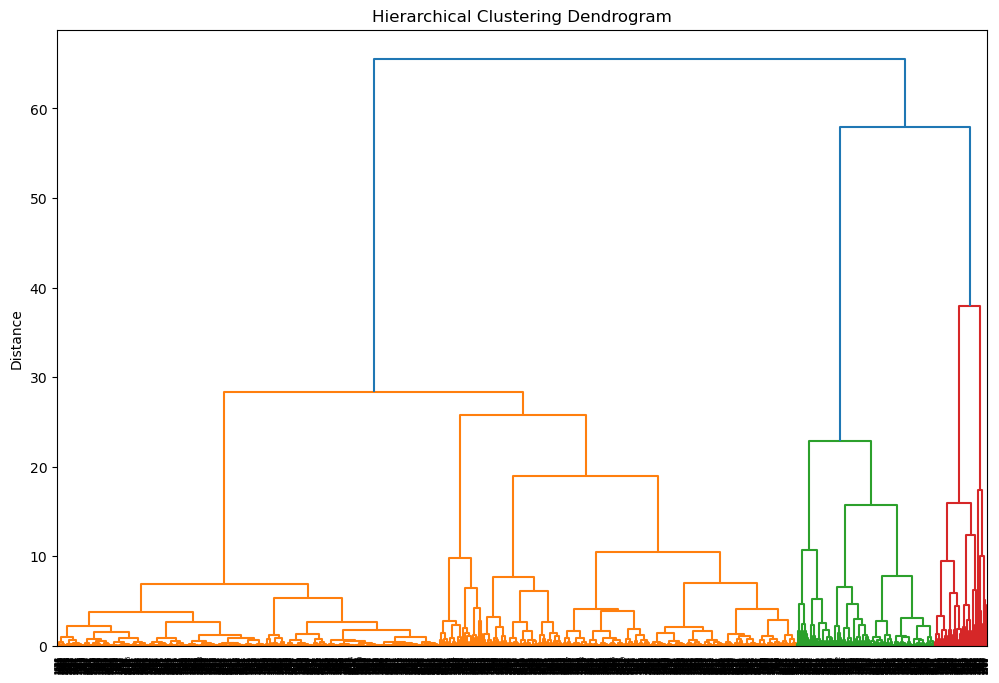

In [297]:
# finding the linkage matrix using Ward's method
Z = linkage(customer_data_scaled, method='ward', metric='euclidean')

plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.show()


In [298]:
max_d = 35  # let's choose 35 as threshold so we get four clusters.
clusters = fcluster(Z, max_d, criterion='distance')

customer_data_no_outliers['Cluster'] = clusters


C:\Users\HEW15DW1083NL\AppData\Local\Temp\ipykernel_37920\3653027880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data_no_outliers['Cluster'] = clusters


In [299]:
cluster_characteristics = customer_data_no_outliers.groupby('Cluster').mean()

print(cluster_characteristics)

           CustomerID  DaysSinceLastPurchase  TotalTransactions     Quantity  \
Cluster                                                                        
1        15520.768043              94.960144           3.204668   468.778815   
2        15657.200772              48.675676           5.515444   809.994208   
3        15464.670807              19.385093          13.465839  3129.173913   
4        15306.000000              29.444444          14.972222  6163.722222   

          TotalPrice  AverageTransactionValue   StockCode  \
Cluster                                                     
1         795.843131               261.382069   33.342908   
2        1464.123726               300.035748  132.393822   
3        4985.132174               411.615630  150.956522   
4        8193.245278               595.113255   67.027778   

         Average_Days_Between_Purchases  Day_Of_Week       Hour  \
Cluster                                                           
1                 

C:\Users\HEW15DW1083NL\AppData\Local\Temp\ipykernel_37920\91069953.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_characteristics = customer_data_no_outliers.groupby('Cluster').mean()


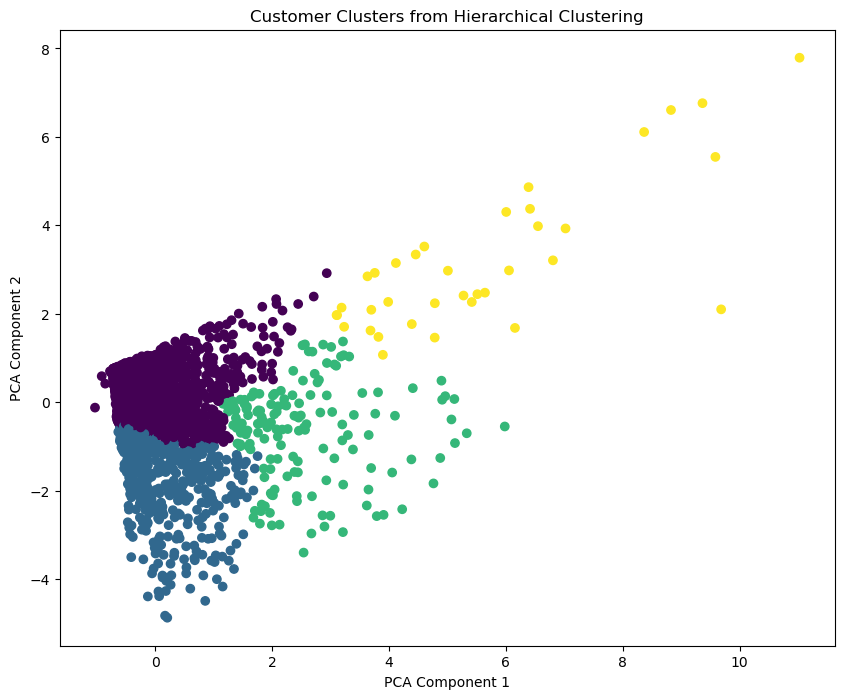

In [300]:
plt.figure(figsize=(10, 8))
plt.scatter(customer_data_scaled[:, 0], customer_data_scaled[:, 1], c=clusters, cmap='viridis')
plt.title('Customer Clusters from Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


#### Q2.3 Based on the analysis, suggest a number of clusters and their characteristics to the head of marketing. Please justify your decisions. (10 points)

### After a thorough analysis utilizing KMeans and hierarchical clustering algorithms, I recommend a customer segmentation model with 4 clusters. This decision is supported by the silhouette scores, which suggest that 4 clusters provide distinct and well-separated groupings of the data. 

### The KMeans clustering method appears to be more appropriate for our dataset for the following reasons:

- Consistency and Separation: The KMeans clusters are more tightly knit and show clear separation between each group, which is ideal for creating distinct marketing segments.

- Outlier Influence: KMeans seems less affected by outliers in this particular instance, which might suggest that it's providing a more robust grouping for our marketing needs.

- Cluster Interpretation: The segmentation derived from KMeans offers a balance of interpretability and actionability that suits broad marketing strategies.

- Operational Efficiency: Managing four clusters is operationally more efficient and can be easily communicated across the marketing team, ensuring everyone is aligned with the segmentation strategy.

### Characteristics of the 4 Clusters Identified by KMeans:

- Cluster 0: This group represents customers with the least frequent interactions and lower transaction volumes, potentially indicating a segment with growth potential. Tailored re-engagement campaigns and special offers could increase their activity.

- Cluster 1: Regular and consistent shoppers with moderate purchase quantities could be targeted with loyalty programs, cross-selling, and upselling strategies to further increase their lifetime value.

- Cluster 2: Customers purchasing large quantities, possibly less frequently, are indicative of bulk buyers or wholesale clients. They could be offered volume-based incentives to maintain their buying patterns.

- Cluster 3: The premium segment with high transaction frequency and volume, these customers are likely to be highly responsive to exclusive offers, premium product lines, and membership programs that cater to their propensity for more significant spending.

### Justification for the Decision:
By choosing four clusters, we strike a balance between sufficient segmentation to tailor marketing campaigns effectively and the manageability of marketing operations. The characteristics of the KMeans clusters suggest clear strategies for customer engagement and revenue maximization. The delineation of clusters allows the marketing team to develop focused initiatives that can be measured for effectiveness and adjusted as needed.

In presenting these findings to the head of marketing, it is essential to highlight that the KMeans model was chosen for its clear segmentation and operational efficiency. This model provides actionable insights that align with strategic marketing objectives and facilitates the design of targeted campaigns aimed at enhancing customer engagement and driving sales growth.







## Question 3: Create a recommendation system that helps the company to increase sales (35 points)


#### Q3.1 Build the recommendation system. (25 points)

In [301]:
df_target = df[['CustomerID', 'StockCode', 'Quantity']]

In [302]:
#CSR Matrix convertion
def create_csr_matrix(df_target):
    item_customer_matrix = df_target.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', fill_value=0)
    csr_item_customer = csr_matrix(item_customer_matrix)
    return csr_item_customer, item_customer_matrix

csr_item_customer, item_customer_matrix = create_csr_matrix(df)

# cosine similarity calculation
def calculate_similarity(csr_matrix):

    similarity_matrix = np.zeros((csr_matrix.shape[0], csr_matrix.shape[0]))
    
    # tqdm loop for progress bar
    for i in tqdm(range(csr_matrix.shape[0]), desc="Calculating Similarities"):
        similarity_matrix[i] = cosine_similarity(csr_matrix[i], csr_matrix).flatten()
    
    return pd.DataFrame(similarity_matrix, index=item_customer_matrix.index, columns=item_customer_matrix.index)

similarity_df = calculate_similarity(csr_item_customer)

Calculating Similarities:   0%|          | 0/3678 [00:00<?, ?it/s]

In [303]:
similarity_df[15034]

StockCode
10002           0.001945
10080           0.016226
10120           0.004452
10125           0.002519
10133           0.021574
                  ...   
90214W          0.000000
90214Y          0.000000
90214Z          0.000000
BANK CHARGES    0.000000
C2              0.000000
Name: 15034, Length: 3678, dtype: float64

In [304]:
def recommend_items(stock_code, similarity_df, items=5):
    similar_scores = similarity_df[stock_code].sort_values(ascending=False)
    
    similar_scores = similar_scores[similar_scores.index != stock_code]
    
    top_items_scores = similar_scores.iloc[:items]
    top_items = top_items_scores.index.tolist()
    
    recommendations = pd.DataFrame({
        'StockCode': top_items,
        'SimilarityScore': top_items_scores.values
    })
    
    return recommendations

# example usage
stock_code = 22613  # input whichever (valid) stockcode
recommendations = recommend_items(stock_code, similarity_df)
print(recommendations)

   StockCode  SimilarityScore
0      23345         0.706752
1      23389         0.685433
2      23512         0.682728
3      23519         0.682335
4      23513         0.679756


In [305]:
# and now finally, let's test our built recommendation system

#manual train test split

split_idx = int(len(df_target) * 0.8)

train_df = df_target[:split_idx]
test_df = df_target[split_idx:]


In [306]:
hits = 0
total = 0

for stock_code in test_df['StockCode'].unique():
    if stock_code in similarity_df.index:
       
        recommendations_df = recommend_items(stock_code, similarity_df)
        
        recommended_stock_codes = recommendations_df['StockCode'].tolist()
        
        test_stock_codes = test_df['StockCode'].unique()
        
        hit = any(rec for rec in recommended_stock_codes if rec in test_stock_codes and rec != stock_code)
        
        if hit:
            hits += 1
        total += 1

hit_rate = hits / total if total > 0 else 0
print(f"Hit Rate: {hit_rate}")


Hit Rate: 0.9776173285198556


#### Q3.2 Based on the analysis, suggest how the model can be used in marketing. Which data would you like to have to improve the results? Please justify your decisions. (10 points)

#### With a remarkable hit rate, our recommendation model stands as a formidable asset for marketers seeking to elevate their strategies and drive sales. This exceptional accuracy not only underscores the effectiveness of our approach but also signifies a potent opportunity to forge deeper connections with customers. Harnessing the insights gleaned from this model, marketers can craft personalized campaigns that resonate on a profound level, ultimately translating into higher engagement and conversion rates.

#### To further enhance the model's efficacy, integrating additional data sources such as demographics, browsing behavior, and feedback enriches customer insights. This data-driven approach ensures recommendations remain relevant, fostering sustained engagement and sales growth.